# Clustering
This is the second notebook of three (2/3). This notebook clusters the user prompts (embedded in the previous notebook) into categories using three methods and then labels each cluster using an LLM.

In [ ]:
# setup colab enviornment and suppress output
%%capture

!pip install bertopic
!pip install hdbscan

# !pip install --upgrade plotly

In [1]:
# general libs
import ast
import random
import pickle
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# bertopic
from hdbscan import HDBSCAN
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.backend import _base
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction

# k-means
from sklearn.cluster import KMeans

Prompts are strings and embeddings are lists.

*   `small_big_tie` is true when a small model and big model tie.
*   `small_beat_big` is true when a small model wins against a big model.
* `model_a_big` and `model_b_big` are true if the respective model is considered big and false if the model is considered false. See Notebook 1 for more details.



In [3]:
# load prepared data
# df = pd.read_pickle('Notebook1_Output.pkl')
df = pd.read_pickle('checkpoint.pkl')
df.head()

,id,prompt,small_big_tie,small_beat_big,winner_tie,winner_model_a,model_a_big,model_a,winner_model_b,model_b_big,model_b,embeddings,reduced_25,reduced_2,kmeans_cluster_id,kmeans_cluster_label,bertopic_cluster_id,bertopic_cluster_label
0,65089,explain function calling. how would you call a...,0,0,1,0,0,gpt-3.5-turbo-0613,0,0,mistral-medium,"[-0.7643815279006958, -0.007776608690619469, -...","[8.414632797241211, 4.291245937347412, 5.09297...","[4.365998268127441, 3.940767526626587]",146,Programming logic and algorithm generation,4,Python Programming and Coding Tasks
1,96401,How can I create a test set for a very rare ca...,0,0,0,1,0,llama-2-13b-chat,0,0,mistral-7b-instruct,"[-0.2905693054199219, 0.005334902089089155, -0...","[8.428787231445312, 4.023136138916016, 4.84389...","[4.172776699066162, 1.9042508602142334]",166,"Machine Learning, Programming, and Technical E...",-1,NaN
2,198779,What is the best way to travel from Tel-Aviv t...,0,0,0,0,0,koala-13b,1,0,gpt-3.5-turbo-0314,"[0.8432239294052124, 0.81766277551651, 0.25694...","[7.988311290740967, 3.9170477390289307, 5.0029...","[6.135153293609619, -2.5313286781311035]",164,Travel Planning and Recommendations,23,Travel Planning and Itinerary Suggestions
3,292873,"Construct a rap battle, in the style of Epic R...",0,0,0,0,0,vicuna-13b,1,1,gpt-4-0314,"[-0.06706339120864868, 0.2793581783771515, -0....","[8.415989875793457, 4.437312602996826, 3.84140...","[1.573264241218567, -3.063511610031128]",30,"Music, lyrics, and songwriting",-1,NaN
4,313413,Why water is not used in bath tub?,0,0,0,1,0,mixtral-8x7b-instruct-v0.1,0,0,vicuna-13b,"[-0.0356348417699337, 0.08141966909170151, 0.3...","[8.144411087036133, 3.667881727218628, 4.65208...","[6.969857692718506, -0.5166858434677124]",115,"Food, Drugs, and Health Queries",-1,NaN


In [4]:
# extract prompts as a list for convenience
prompts = df['prompt'].to_list()

# extract embeddings as numpy arrays (for BERTopic)
embeddings25 = np.array(df['reduced_25'].tolist())

# extract embeddings as numpy arrays (for 2D analysis)
embeddings2 = np.array(df['reduced_2'].tolist())

# Cluster Summarization
In order to analyze clusters, we use an LLM to summarize the topic of each given sample prompts. We do not have access to an API (with enough free tokens) so we copy-paste generated prompts into ChatGPT 4o mini. Since we're using this manual process, we generate a CSV, fill it in as a google sheet, and then export as a CSV again to import as a df. This also allows for manual corrections. An API could be used instead.

The following section includes a reusable function to label clusters created by one of the three methods. The actual summarization will be run after clustering for each method later in this document.

In [2]:
def generateLabels(clusters, cutoff=50, points_per_cluster=20):
  """Generates labels for clusters given a sampling of prompts.

  Args:
    clusters: A dictionary where keys are cluster ids with their
      corresponding prompts in lists of strings.
    cutoff: The minimum number of prompts needed to consider a cluster for labeling.
    points_per_cluster: The number of prompts to sample from each cluster for
      theme analysis.

  Returns:
    None. Saves a CSV file named 'cluster_labels.csv' with cluster ID,
      sample prompts, and a placeholder for the label. The sample prompts can be
      directly copy/pasted into chatGPT for labeling.
  """
  if clusters is None:
      raise ValueError("Clusters cannot be None.")

  with open('cluster_labels.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['cluster_id', 'sample_prompts', 'label'])  # Header row

    for cid, prompts in clusters.items():
      if len(prompts) >= cutoff:
          # Only sample some prompts
          sample_prompts = random.sample(prompts, min(points_per_cluster, len(prompts)))

          # Truncate prompts to 150 characters
          truncated_prompts = [p[:150] + "..." if len(p) > 150 else p for p in sample_prompts]

          # Create the ChatGPT prompt
          chatgpt_prompt = f"I have a semantic cluster of LLM prompts people have asked. I need you to" \
                            + " give a specific, concise label in a few words. Since I already know" \
                            + " these are likely questions or prompts, ignore that." \
                            + " Given a few random samples," \
                            + " describe this cluster: \n" \
                            + "\n".join(f"- {p} " for p in truncated_prompts)

          # Write the cluster ID, sample prompts string, and an empty label to the CSV
          writer.writerow([cid, chatgpt_prompt, ''])
      else:
          # For clusters below the cutoff, write the cluster ID and 'null' label
          writer.writerow([cid, '', 'null'])

# K-Means Clustering
K-means is a clustering method that partitions data into $k$ clusters by minimizing the variance within each cluster. K-means aims to minimize the sum of squared distances between data points and their assigned cluster centroids, making it sensitive to the initial selection of centroids and the number of clusters.

In [ ]:
# create matrix (stack the embeddings in a 2D array)
embeddings_matrix = np.vstack(embeddings25)

# Define number of clusters - Same number of clusters present in BERTopic
n_clusters = 180

# Initialize KMeans and fit the model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings_matrix)

# Get the centroids of the clusters
centroids = kmeans.cluster_centers_

# Add to df
df['kmeans_cluster_id'] = clusters
df.head(3)

,id,prompt,small_big_tie,small_beat_big,winner_tie,winner_model_a,model_a_big,model_a,winner_model_b,model_b_big,model_b,embeddings,reduced_25,reduced_2,kmeans_cluster_id
0,65089,explain function calling. how would you call a...,0,0,1,0,0,gpt-3.5-turbo-0613,0,0,mistral-medium,"[-0.7643815279006958, -0.007776608690619469, -...","[8.414632797241211, 4.291245937347412, 5.09297...","[4.365998268127441, 3.940767526626587]",146
1,96401,How can I create a test set for a very rare ca...,0,0,0,1,0,llama-2-13b-chat,0,0,mistral-7b-instruct,"[-0.2905693054199219, 0.005334902089089155, -0...","[8.428787231445312, 4.023136138916016, 4.84389...","[4.172776699066162, 1.9042508602142334]",166
2,198779,What is the best way to travel from Tel-Aviv t...,0,0,0,0,0,koala-13b,1,0,gpt-3.5-turbo-0314,"[0.8432239294052124, 0.81766277551651, 0.25694...","[7.988311290740967, 3.9170477390289307, 5.0029...","[6.135153293609619, -2.5313286781311035]",164


### Visualization

We can visualize our clusters in 2D by reducing the dimension with UMAP to two and plotting the result.

Here, each color represents a different cluster and, of course, each cluster represents prompts within a related theme

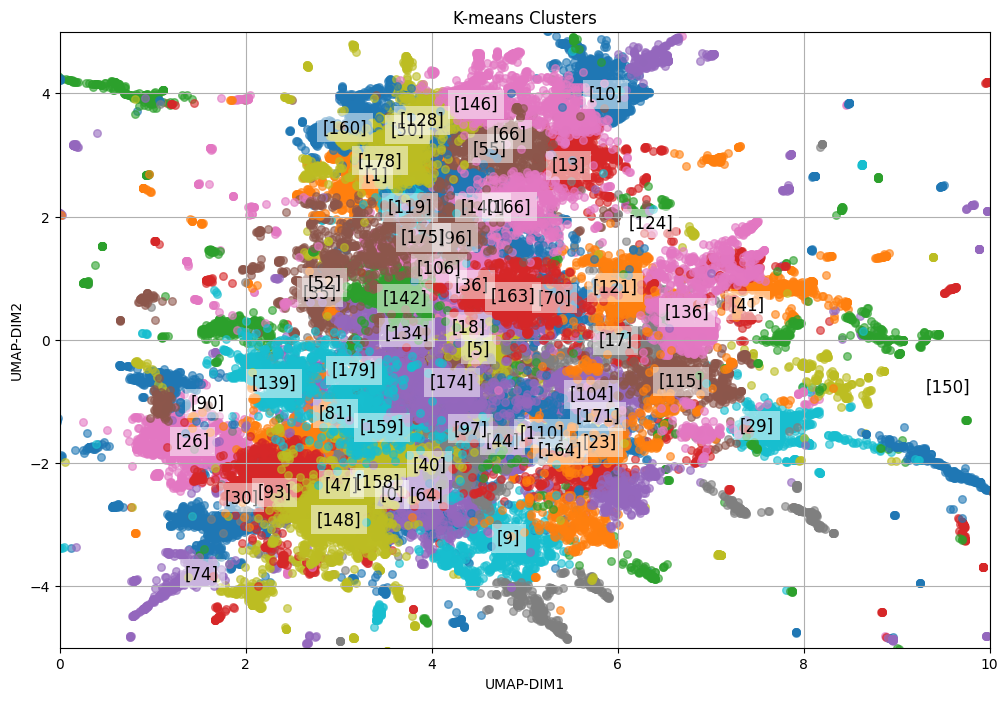

In [ ]:
# Plot the data points of each cluster in 2D space
plt.figure(figsize=(12, 8))

# Loop through each cluster and plot
for cluster in range(n_clusters):
    # Filter data points belonging to the current cluster
    cluster_data = embeddings2[clusters == cluster]

    # Check if the cluster is large enough
    if len(cluster_data) > 400:
        # Calculate the centroid of the cluster
        centroid_x = np.mean(cluster_data[:, 0])
        centroid_y = np.mean(cluster_data[:, 1])

        # Add a label to the centroid
        plt.text(centroid_x, centroid_y, f'[{cluster}]', fontsize=12, ha='center', va='center',
                 bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Plot the data points for the current cluster
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}', s=30, alpha=0.6)


# Plot configuration
plt.title('K-means Clusters')
plt.xlabel('UMAP-DIM1')
plt.ylabel('UMAP-DIM2')
plt.xlim(0, 10)  # Set the x-axis limits
plt.ylim(-5, 5)  # Set the y-axis limits
plt.grid()
plt.show()

### Topic Labels

In [ ]:
# from the df, make a dictionary where each key is a unique cluster and each key has a list of the prompts
kmeans_clusters = {}
for i in range(n_clusters):
  kmeans_clusters[i] = df[df['kmeans_cluster_id'] == i]['prompt'].to_list()

# generate labels for each function
kmeans_labels = generateLabels(kmeans_clusters)

The cell above exports a CSV that can be opened in google sheets and edited to add labels. Once complete, the CSV should be uploaded here to be turned into a df and merged with the rest of the data.

In [ ]:
# import csv as df
kmeans_df = pd.read_csv("cluster_labels - kmeans_cluster_labels.csv")

# add to df
df['kmeans_cluster_label'] = df['kmeans_cluster_id'].map(kmeans_df['label'])
df.head(3)

,id,prompt,small_big_tie,small_beat_big,winner_tie,winner_model_a,model_a_big,model_a,winner_model_b,model_b_big,model_b,embeddings,reduced_25,reduced_2,kmeans_cluster_id,kmeans_cluster_label
0,65089,explain function calling. how would you call a...,0,0,1,0,0,gpt-3.5-turbo-0613,0,0,mistral-medium,"[-0.7643815279006958, -0.007776608690619469, -...","[8.414632797241211, 4.291245937347412, 5.09297...","[4.365998268127441, 3.940767526626587]",146,Programming logic and algorithm generation
1,96401,How can I create a test set for a very rare ca...,0,0,0,1,0,llama-2-13b-chat,0,0,mistral-7b-instruct,"[-0.2905693054199219, 0.005334902089089155, -0...","[8.428787231445312, 4.023136138916016, 4.84389...","[4.172776699066162, 1.9042508602142334]",166,"Machine Learning, Programming, and Technical E..."
2,198779,What is the best way to travel from Tel-Aviv t...,0,0,0,0,0,koala-13b,1,0,gpt-3.5-turbo-0314,"[0.8432239294052124, 0.81766277551651, 0.25694...","[7.988311290740967, 3.9170477390289307, 5.0029...","[6.135153293609619, -2.5313286781311035]",164,Travel Planning and Recommendations


# BERTopic Clustering
BERTopic uses transformers and TF-IDF to create clusters.

The code block below defines and runs the topic model. Note that we already embedded our prompts using Sentence Transformer in notebook 1. We need to create a custom class to skip the embedding step and use our own embeddings.

The printed output represents topics and how frequent they are. Note that -1 refers to outliers.

In [ ]:
class EmptyEmbedder(_base.BaseEmbedder):
    """The Base Embedder used for creating embedding models."""

    def __init__(self, embedding_model=None, word_embedding_model=None):
      self.embedding_model = embedding_model
      self.word_embedding_model = word_embedding_model

    def embed(self, documents, verbose):
      # return the pre-processes embeddings from notebook 1
      return embeddings25

# empty UMAP model since the data dimensions has already been reduced
empty_dimensionality_model = BaseDimensionalityReduction()

# HBDSCAN is the algorithm that groups points into clusters
hdbscan_model = HDBSCAN(
    min_cluster_size = 32,
    metric = 'euclidean',
    cluster_selection_method = 'eom',
    prediction_data = True
  )

topic_model = BERTopic(
  embedding_model = EmptyEmbedder(),                        # Step 1 - Keep embeddings the same
  umap_model = empty_dimensionality_model,                  # Step 2 - Keep dimensionality the same
  hdbscan_model = hdbscan_model,                            # Step 3 - Cluster reduced embeddings
  vectorizer_model = CountVectorizer(stop_words="english"), # Step 4 - Tokenize topics
  ctfidf_model = ClassTfidfTransformer(),                   # Step 5 - Extract topic words
  representation_model = KeyBERTInspired()                  # Step 6 - (Optional) Fine-tune topic representations
)

# run model
topics, probs = topic_model.fit_transform(prompts, embeddings25)
print(topic_model.get_topic_info())

# add to df
df['bertopic_cluster_id'] = topics
df.head(3)

     Topic  Count                                           Name  \
0       -1  28709                         -1_list_true_help_step   
1        0    788               0_labels_language_droning_arabic   
2        1    694          1_commands_manipulation_adventure_mtg   
3        2    651                      2_unit_bowl_dish_calories   
4        3    586                      3_musical_music_lyric_lil   
..     ...    ...                                            ...   
175    174     33              174_statue_towers_starts_settlers   
176    175     33             175_bioiudhfoidsh_tell_ducks_table   
177    176     32        176_lovable_brooding_qualities_choleric   
178    177     32              177_female_waitress_guy_shrinking   
179    178     32  178_opposite_identical_accelerometer_exterior   

                                        Representation  \
0    [list, true, help, step, language, type, diffe...   
1    [labels, language, droning, arabic, pc_knowled...   
2    [com

,id,prompt,small_big_tie,small_beat_big,winner_tie,winner_model_a,model_a_big,model_a,winner_model_b,model_b_big,model_b,embeddings,reduced_25,reduced_2,kmeans_cluster_id,kmeans_cluster_label,bertopic_cluster_id
0,65089,explain function calling. how would you call a...,0,0,1,0,0,gpt-3.5-turbo-0613,0,0,mistral-medium,"[-0.7643815279006958, -0.007776608690619469, -...","[8.414632797241211, 4.291245937347412, 5.09297...","[4.365998268127441, 3.940767526626587]",146,Programming logic and algorithm generation,4
1,96401,How can I create a test set for a very rare ca...,0,0,0,1,0,llama-2-13b-chat,0,0,mistral-7b-instruct,"[-0.2905693054199219, 0.005334902089089155, -0...","[8.428787231445312, 4.023136138916016, 4.84389...","[4.172776699066162, 1.9042508602142334]",166,"Machine Learning, Programming, and Technical E...",-1
2,198779,What is the best way to travel from Tel-Aviv t...,0,0,0,0,0,koala-13b,1,0,gpt-3.5-turbo-0314,"[0.8432239294052124, 0.81766277551651, 0.25694...","[7.988311290740967, 3.9170477390289307, 5.0029...","[6.135153293609619, -2.5313286781311035]",164,Travel Planning and Recommendations,23


### Visualization
The BERTopic library allows us to visualize clusters with an easy function. We also explored hierarchical clustering but are not including it here.

In [ ]:
topic_model.visualize_topics()

### Topic Labels


In [ ]:
# from the df, make a dictionary where each key is a unique cluster and each key has a list of the prompt
bertopic_clusters = {}
for i in range(len(topic_model.get_topic_info())):
  bertopic_clusters[i] = df[df['bertopic_cluster_id'] == i]['prompt'].to_list()

# generate labels
bertopic_labels = generateLabels(bertopic_clusters)

In [ ]:
# import csv as df
bertopic_df = pd.read_csv("cluster_labels - bertopic_cluster_labels.csv")

# add to df
df['bertopic_cluster_label'] = df['bertopic_cluster_id'].map(bertopic_df['label'])
df.head(3)

,id,prompt,small_big_tie,small_beat_big,winner_tie,winner_model_a,model_a_big,model_a,winner_model_b,model_b_big,model_b,embeddings,reduced_25,reduced_2,kmeans_cluster_id,kmeans_cluster_label,bertopic_cluster_id,bertopic_cluster_label
0,65089,explain function calling. how would you call a...,0,0,1,0,0,gpt-3.5-turbo-0613,0,0,mistral-medium,"[-0.7643815279006958, -0.007776608690619469, -...","[8.414632797241211, 4.291245937347412, 5.09297...","[4.365998268127441, 3.940767526626587]",146,Programming logic and algorithm generation,4,Python Programming and Coding Tasks
1,96401,How can I create a test set for a very rare ca...,0,0,0,1,0,llama-2-13b-chat,0,0,mistral-7b-instruct,"[-0.2905693054199219, 0.005334902089089155, -0...","[8.428787231445312, 4.023136138916016, 4.84389...","[4.172776699066162, 1.9042508602142334]",166,"Machine Learning, Programming, and Technical E...",-1,NaN
2,198779,What is the best way to travel from Tel-Aviv t...,0,0,0,0,0,koala-13b,1,0,gpt-3.5-turbo-0314,"[0.8432239294052124, 0.81766277551651, 0.25694...","[7.988311290740967, 3.9170477390289307, 5.0029...","[6.135153293609619, -2.5313286781311035]",164,Travel Planning and Recommendations,23,Travel Planning and Itinerary Suggestions


# 2D Grid Clustering

This is the most naive clustering method. We simply plot the embeddings and apply a grid onto the graph, dividing them into 16 squares. We take each square as a cluster and analyze them accordingly.

In [5]:
clusterNum = 16 #number of clusters (perfect square)
lineNum = int(clusterNum**0.5)

#range of data to include
xMax = 9.5
xMin = 0
yMax = 5
yMin = -5
xRange = xMax - xMin
yRange = yMax - yMin


In [6]:
#calculates the grid lines
xLines = []
yLines = []
xUnit = xRange/lineNum
yUnit = yRange/lineNum

for i in range(lineNum+1):
        xLines.append(xMin + i*xUnit)
        yLines.append(yMin + i*yUnit)

In [7]:
#filters the embeddings data according to the specified data range
embeddings3 = np.array(df[df['reduced_2'].apply(
          lambda x: x[0] > xMin and x[1] > yMin and x[0] < xMax and x[1]<yMax)]['reduced_2'].tolist())

### Topic Labels

In [12]:
# dictionary where each key is a unique cluster and each key has a list of the prompt
grid_clusters = {}
cluster_id = 0  # Initialize a cluster ID counter

for i in range(len(xLines) - 1):
    for j in range(len(yLines) - 1):
        # Filter data points within the current grid cell
        cluster_data = df[df['reduced_2'].apply(
            lambda x: x[0] > xLines[i] and x[1] > yLines[j] and x[0] < xLines[i + 1] and x[1] < yLines[j + 1])]

        # If there are prompts in this cluster, add them to the dictionary
        if len(cluster_data) > 0:
            grid_clusters[cluster_id] = cluster_data['prompt'].tolist()
            cluster_id += 1  # Increment cluster ID for the next cluster


# generate lables, since these are very broad we'll use more samples
grid_labels = generateLabels(grid_clusters, points_per_cluster=50)

# add id to df
for index, row in df.iterrows():
  for key, value in grid_clusters.items():
    if row['prompt'] in value:
      df.at[index, 'grid_cluster_id'] = int(key)
      break

In [14]:
# import csv as df
grid_df = pd.read_csv("cluster_labels - grid_cluster_labels.csv")

# add to df
df['grid_cluster_label'] = df['grid_cluster_id'].map(grid_df['label'])
df.head(3)

,id,prompt,small_big_tie,small_beat_big,winner_tie,winner_model_a,model_a_big,model_a,winner_model_b,model_b_big,model_b,embeddings,reduced_25,reduced_2,kmeans_cluster_id,kmeans_cluster_label,bertopic_cluster_id,bertopic_cluster_label,grid_cluster_id,grid_cluster_label
0,65089,explain function calling. how would you call a...,0,0,1,0,0,gpt-3.5-turbo-0613,0,0,mistral-medium,"[-0.7643815279006958, -0.007776608690619469, -...","[8.414632797241211, 4.291245937347412, 5.09297...","[4.365998268127441, 3.940767526626587]",146,Programming logic and algorithm generation,4,Python Programming and Coding Tasks,7.0,"Programming, Tech Support, and Algorithm Guidance"
1,96401,How can I create a test set for a very rare ca...,0,0,0,1,0,llama-2-13b-chat,0,0,mistral-7b-instruct,"[-0.2905693054199219, 0.005334902089089155, -0...","[8.428787231445312, 4.023136138916016, 4.84389...","[4.172776699066162, 1.9042508602142334]",166,"Machine Learning, Programming, and Technical E...",-1,NaN,6.0,"Tech, Engineering, and Practical Problem-Solving"
2,198779,What is the best way to travel from Tel-Aviv t...,0,0,0,0,0,koala-13b,1,0,gpt-3.5-turbo-0314,"[0.8432239294052124, 0.81766277551651, 0.25694...","[7.988311290740967, 3.9170477390289307, 5.0029...","[6.135153293609619, -2.5313286781311035]",164,Travel Planning and Recommendations,23,Travel Planning and Itinerary Suggestions,8.0,"Geopolitics, History, and Trivia"


### Visualization

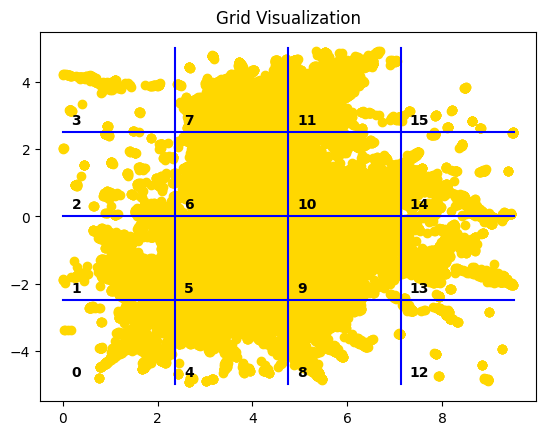

In [8]:
plt.scatter(embeddings3[:,0], embeddings3[:,-1], color = "gold")
for i in range(1, lineNum):
    plt.plot([xLines[i], xLines[i]], [yLines[0], yLines[-1]], color='b')
    plt.plot([xLines[0], xLines[-1]], [yLines[i], yLines[i]], color='b')
cluster_id = 0
for i in range(len(xLines)-1):
  for j in range(len(yLines)-1):
    position = ((xLines[i] + xLines[i+1])/2-1, (yLines[j]+ yLines[j+1])/2-1)
    plt.text(position[0], position[1], cluster_id, fontsize=10, weight="bold")
    cluster_id += 1
plt.title("Grid Visualization")
plt.show()

In [27]:
for index, row in grid_df.iterrows():
    cluster_id = row['cluster_id']
    label = row['label']
    print(f"Cluster {cluster_id}: {label}")

Cluster 0: Creative and Quirky Writing Prompts
Cluster 1: Diverse Knowledge and Creative Tasks
Cluster 2: Wordplay and Logical Challenges
Cluster 3: Time, Dates, and Logical Puzzles
Cluster 4: General Knowledge and Historical Contextualization
Cluster 5: Creative Expression and Philosophical Inquiry
Cluster 6: Tech, Engineering, and Practical Problem-Solving
Cluster 7: Programming, Tech Support, and Algorithm Guidance
Cluster 8: Geopolitics, History, and Trivia
Cluster 9: Practical Knowledge and Everyday Curiosities
Cluster 10: Technical Concepts, Problem-Solving, and Practical Advice
Cluster 11: Mathematics, Algorithms, and Coding Concepts
Cluster 12: Health, Optometry, and General Knowledge
Cluster 13: Food, Health, and Puzzles
Cluster 14: Science, Puzzles, and Thought Experiments
Cluster 15: Fantasy Roleplay, Wealth, and Interactive Entertainment


# Export Data for Notebook 3

In [17]:
# remove embeddings columns
df = df.drop(columns=['reduced_25', 'embeddings'])

# to pickle
df.to_pickle('Notebook2_Output.pkl')
print('done')
df.head(100)

done


,id,prompt,small_big_tie,small_beat_big,winner_tie,winner_model_a,model_a_big,model_a,winner_model_b,model_b_big,model_b,reduced_2,kmeans_cluster_id,kmeans_cluster_label,bertopic_cluster_id,bertopic_cluster_label,grid_cluster_id,grid_cluster_label
0,65089,explain function calling. how would you call a...,0,0,1,0,0,gpt-3.5-turbo-0613,0,0,mistral-medium,"[4.365998268127441, 3.940767526626587]",146,Programming logic and algorithm generation,4,Python Programming and Coding Tasks,7.0,"Programming, Tech Support, and Algorithm Guidance"
1,96401,How can I create a test set for a very rare ca...,0,0,0,1,0,llama-2-13b-chat,0,0,mistral-7b-instruct,"[4.172776699066162, 1.9042508602142334]",166,"Machine Learning, Programming, and Technical E...",-1,NaN,6.0,"Tech, Engineering, and Practical Problem-Solving"
2,198779,What is the best way to travel from Tel-Aviv t...,0,0,0,0,0,koala-13b,1,0,gpt-3.5-turbo-0314,"[6.135153293609619, -2.5313286781311035]",164,Travel Planning and Recommendations,23,Travel Planning and Itinerary Suggestions,8.0,"Geopolitics, History, and Trivia"
3,292873,"Construct a rap battle, in the style of Epic R...",0,0,0,0,0,vicuna-13b,1,1,gpt-4-0314,"[1.573264241218567, -3.063511610031128]",30,"Music, lyrics, and songwriting",-1,NaN,0.0,Creative and Quirky Writing Prompts
4,313413,Why water is not used in bath tub?,0,0,0,1,0,mixtral-8x7b-instruct-v0.1,0,0,vicuna-13b,"[6.969857692718506, -0.5166858434677124]",115,"Food, Drugs, and Health Queries",-1,NaN,9.0,Practical Knowledge and Everyday Curiosities
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,8173595,Reality as a guide,0,0,1,0,0,gpt-3.5-turbo-1106,0,0,llama-2-13b-chat,"[4.0527873039245605, -1.7137809991836548]",97,"Philosophy, Law, & Social Issues",-1,NaN,5.0,Creative Expression and Philosophical Inquiry
96,8322953,prevent ai detection for my paragraph,0,0,0,0,0,vicuna-7b,1,0,llama-2-7b-chat,"[3.28458833694458, 0.7459022402763367]",142,"AI, Ethics, and Innovation",-1,NaN,6.0,"Tech, Engineering, and Practical Problem-Solving"
97,8627100,Which of the following is capable of existing ...,0,0,0,0,0,claude-instant-1,1,1,llama-2-70b-chat,"[6.811643123626709, -0.15241439640522003]",136,Science and Technical Explanations,22,Chemistry Calculations and Experimental Proced...,9.0,Practical Knowledge and Everyday Curiosities
98,8639923,What is the most famous movie by ozu and why?,0,1,0,1,0,gpt-3.5-turbo-1106,0,1,pplx-70b-online,"[2.311753749847412, -2.608505964279175]",93,Storytelling & Fiction Creation,8,"Creative Writing, Film, and Storytelling Concepts",0.0,Creative and Quirky Writing Prompts
